In [20]:
import nest_asyncio
nest_asyncio.apply()

In [65]:
def main(list, time, flag):
    import pandas as pd
    import numpy as np
    import matplotlib as plt
    import numpy as matrix

    meta_data = np.zeros((time, 200))

    # Extract the stock data from Yahoo
    num_stocks_portfolio = 0
    if flag != 1:
        for x in list:
            current_stock = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/"+x
                                    +"?period1=1433116800&period2=1619308800&interval=1d&events="
                                    +"history&includeAdjustedClose=true")
            if len(current_stock) <= time:
                continue

            current_stock_close = current_stock['Close']
            meta_data[:, num_stocks_portfolio] = current_stock_close[-time:]
            num_stocks_portfolio += 1
    # Extract Crypto from Binance
    else:
        for x in list:
            current_stock = get_all_binance(x, '1m', save = True)
    
            if len(current_stock) <= time:
                    continue

            current_stock_close = current_stock['close']
            meta_data[:, num_stocks_portfolio] = current_stock_close[-time:]
            num_stocks_portfolio += 1
    
    # eliminate last n columns 
    meta_data = meta_data[:-1, :]
    meta_data = meta_data[:, :num_stocks_portfolio]
    meta_data_lag = meta_data[:-1, :]
    meta_data = meta_data[1:, :]

    # compute daily returns
    daily_returns = np.divide(np.subtract(meta_data, meta_data_lag), meta_data_lag)
    #print(daily_returns)
    
    # compute market returns
    market_returns = np.mean(daily_returns, axis=1)
    market_returns = np.tile(market_returns, (num_stocks_portfolio, 1))
    market_returns = np.matrix.transpose(market_returns)
    #print(market_returns)

    weights = -(daily_returns - market_returns)
    #print(weights)
    

    weights = weights/pd.DataFrame(np.abs(weights)).sum(axis=1).values.reshape((weights.shape[0], 1))
    #print(weights)
    
    totalDailyRet = (pd.DataFrame(weights).shift()*daily_returns).sum(axis=1)

    
    ((1+totalDailyRet).cumprod()-1).plot()
    plt.pyplot.show()


    APR = (np.prod(1+totalDailyRet))**(252/len(totalDailyRet)) -1
 
    Sharpe = np.sqrt(252)*np.mean(totalDailyRet)/np.std(totalDailyRet)

    #NOTE: cumprod will create an increasing vector of cumulative product at each point
    print("This is Monthly return")
    print(APR)
    print("This is Sharpe")
    print(Sharpe)

In [53]:
import pandas as pd
import math
import os.path
import time
from bitmex import bitmex
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)

### API
bitmex_api_key = ''    #Enter your own API-key here
bitmex_api_secret = '' #Enter your own API-secret here
binance_api_key = ''    #Enter your own API-key here
binance_api_secret = '' #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)
binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)

### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Apr 2021', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

import asyncio
async def get_all_tardis(*symbols):
    from tardis_dev import datasets
    datasets.download(
        exchange="bitmex",
        data_types=["trades"],
        from_date="2021-04-12",
        to_date="2021-04-28",
        symbols= symbols,
        api_key="TD.DPgWHdw6g8MVojvQ.WVt-I5iaYeOUeHV.ya9VDZXlhKlPDbI.CpnH4VLpAN1kdtJ.lg6yktNRehqCPw2.2ZV9",
        )

In [52]:
asyncio.run(get_all_tardis("ADAUSDT", "XRPUSD", "XLMUSDT"))

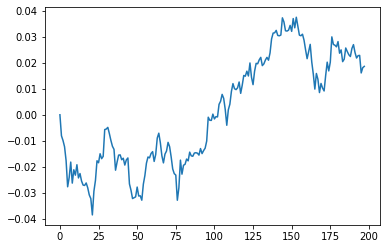

This is Monthly return
0.0237908532293698
This is Sharpe
0.42417316574233993


In [69]:
#[['CZK=X','HUF=X']]#[['^GSPC','IBM']]#,['^GSPC','HPE'],['^GSPC','DXC'],['^GSPC','GOOG'],['^GSPC','AMZN'],['^GSPC','FB']]
#['BTC-USD','ETH-USD','EOS-USD','XTZ-USD','XLM-USD']:    
#['GBPUSD=X','CZK=X','RON=X','DKK=X','EURUSD=X']:
#['FB','AMZN','GOOG','HPE','IBM']:
#['NVS','WIT','GOOG','HPE','IBM','DXC','GE']:
lists = [['GOOG','IBM']]
lists = [['GBPUSD=X','CZK=X','RON=X','DKK=X','EURUSD=X']]
for list in lists:
    main(list, 200, 0)

All caught up..!
All caught up..!
pamameters: 1997.6680051, 0.0034222


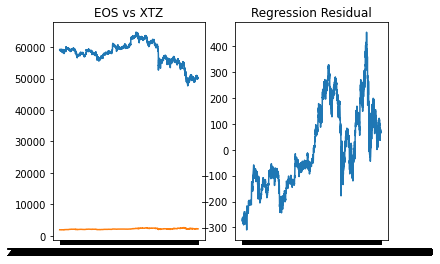

Pearson correlation coefficient:0.0766479
(-2.273102663983786, 0.18078967204250979, 1, 6919, {'1%': -3.43129547300656, '5%': -2.8619578223405884, '10%': -2.566992402946022}, 47423.12387193999)
pamameters: 54189.3768652, 1.7167199
(-0.5557667479651867, 0.8806670153172234, 1, 6919, {'1%': -3.43129547300656, '5%': -2.8619578223405884, '10%': -2.566992402946022}, 86585.18511915216)


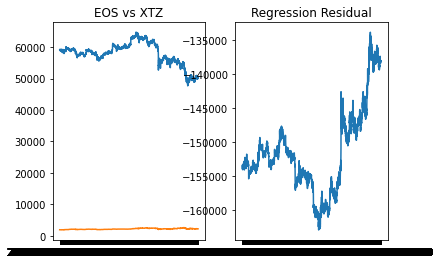

[7.08050579 0.02468464]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[[ 5.74976419e-05  2.78751033e-04]
 [ 6.12490481e-03 -1.76172877e-03]]


In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

#################################################### Data #####################################################
eos_price = get_all_binance("XRPUSDT", '5m', save = True)['close'][:-1000]
eos_price.name = 'EOS US Equity'

xtz_price = get_all_binance("ADAUSDT", '5m', save = True)['close'][:-1000]
xtz_price.name = 'XTZ US Equity'

data = pd.concat([eos_price, xtz_price], axis=1)
# print(data[data.isnull().any(axis=1)])
data.dropna(axis=0, how='any',inplace=True)

from sklearn.linear_model import LinearRegression
# The next two lines does the regression
lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data['EOS US Equity'].values.reshape(-1,1), data['XTZ US Equity'].values)        # fit() expects 2D array
print('pamameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))

# present the graph
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('EOS vs XTZ')
ax[0].plot(data)
yfit = lm_model.coef_ * data['EOS US Equity'] + lm_model.intercept_
y_residual = data['XTZ US Equity'] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual)
plt.show()

from scipy.stats.stats import pearsonr
print('Pearson correlation coefficient:%.7f' %(pearsonr(data['EOS US Equity'], data['XTZ US Equity'])[0]))
####################################### CADF #####################################################
import statsmodels.tsa.stattools as ts
print(ts.adfuller(y_residual, 1))           # lag = 1

lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data['XTZ US Equity'].values.reshape(-1,1), data['EOS US Equity'].values)        # fit() expects 2D array
print('pamameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))
yfit = lm_model.coef_ * data['XTZ US Equity'] + lm_model.intercept_
y_residual = data['EOS US Equity'] - yfit
print(ts.adfuller(y_residual, 1))           # lag = 1

# present the graph
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('EOS vs XTZ')
ax[0].plot(data)
yfit = lm_model.coef_ * data['EOS US Equity'] + lm_model.intercept_
y_residual = data['XTZ US Equity'] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual)
plt.show()

####################################### Johansen #####################################################
from statsmodels.tsa.vector_ar.vecm import coint_johansen
data = data.astype(float)
jh_results = coint_johansen(data, 0, 1)             # 0 - constant term; 1 - log 1
print(jh_results.lr1)                           # dim = (n,) Trace statistic
print(jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print(jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]

# [21.44412674  3.64194243]                 # trace statistic
# [[13.4294 15.4943 19.9349]                # r = 0 critical values
#  [ 2.7055  3.8415  6.6349]]               # r <= 1 critical values
# [[ 0.53474958  0.02398649]                # eigenvectors
#  [-0.45169106  0.12036402]]

In [48]:
import pandas as pd 
from datetime import datetime
df = pd.read_csv('ada-uni.zip')
df['timestamp'] = pd.to_datetime(df['timestamp'])

ada = df[(df.symbol == "ADAUSDT")].set_index('timestamp')
uni = df[(df.symbol == "UNIUSDT")].set_index('timestamp')

df = pd.read_csv('bitmex.zip')
df['timestamp'] = pd.to_datetime(df['timestamp'])


xrp = df[(df.symbol == "XRPUSD")].set_index('timestamp')
xlm = df[(df.symbol == "XLMUSDT")].set_index('timestamp')

,symbol,price,amount,side,timestamp
0,XRPUSD,1.3576,1412.0,buy,2021-04-12 00:00:04.870000+00:00
1,XRPUSD,1.3577,92.0,buy,2021-04-12 00:00:04.892000+00:00
2,XRPUSD,1.3584,337.0,buy,2021-04-12 00:00:04.892000+00:00
3,XRPUSD,1.3583,1250.0,buy,2021-04-12 00:00:04.997000+00:00
4,XRPUSD,1.3584,709.0,buy,2021-04-12 00:00:05.048000+00:00
...,...,...,...,...,...
1146528,XRPUSD,1.3710,93.0,buy,2021-04-26 23:59:52.399000+00:00
1146529,XRPUSD,1.3695,40.0,sell,2021-04-26 23:59:58.499000+00:00
1146530,XRPUSD,1.3693,21.0,sell,2021-04-26 23:59:58.521000+00:00
1146531,XRPUSD,1.3683,200.0,sell,2021-04-26 23:59:59.475000+00:00


In [49]:
xrp1 = xrp.price.resample('300S').ohlc()
ada1 = ada.price.resample('300S').ohlc()
vol = xrp.amount.resample('300S').sum()

pamameters: 0.5715382, 0.5014567


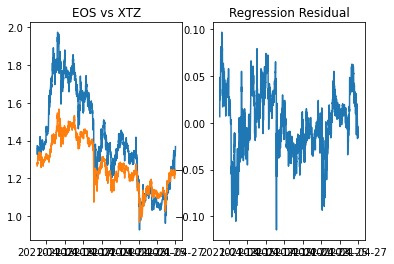

Pearson correlation coefficient:0.9631176
(-1.7521333798302596, 0.40447148569616337, 1, 4677, {'1%': -3.4317489507556433, '5%': -2.8621581755637417, '10%': -2.5670990572158807}, -24211.111982373674)
pamameters: -0.9528189, 1.8498020
(-5.089710964838059, 1.4702440200839131e-05, 1, 2802, {'1%': -3.4326859389144238, '5%': -2.8625720543052755, '10%': -2.56731939418209}, -15473.994298590696)


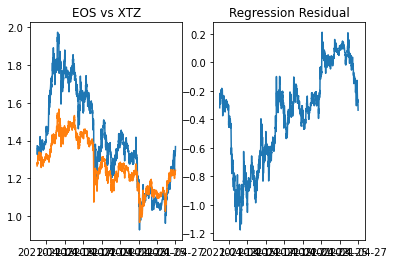

[29.2315725   2.23251075]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
[[ 14.73282372  -3.38018407]
 [-29.0123235   -1.30349079]]


In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
import numpy as np

#################################################### Data #####################################################
#eos_price = get_all_binance("EOSUSDT", '1m', save = True)['close'][:1000]


#xrp1 = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/"+ "EURUSD=X"
#                                    +"?period1=1433116800&period2=1619308800&interval=1d&events="
#                                    +"history&includeAdjustedClose=true")['Close']

#xtz_price = get_all_binance("XTZUSDT", '1m', save = True)['close'][:1000]
xrp1 = xrp1['close']#[:10000]
xrp1.name = 'EOS US Equity'

#xlm1 = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/"+ "GBPUSD=X"
#                                    +"?period1=1433116800&period2=1619308800&interval=1d&events="
#                                    +"history&includeAdjustedClose=true")['Close']
xlm1 = ada1['close']#[:10000]
xlm1.name = 'XTZ US Equity'
data = pd.concat([xrp1, xlm1], axis=1)
# print(data[data.isnull().any(axis=1)])
data.dropna(axis=0, how='any',inplace=True)

from sklearn.linear_model import LinearRegression
# The next two lines does the regression
lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data['EOS US Equity'].values.reshape(-1,1), data['XTZ US Equity'].values)        # fit() expects 2D array
print('pamameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))

# present the graph
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('EOS vs XTZ')
ax[0].plot(data)
yfit = lm_model.coef_ * data['EOS US Equity'] + lm_model.intercept_
y_residual1 = data['XTZ US Equity'] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual1)
plt.show()

from scipy.stats.stats import pearsonr
print('Pearson correlation coefficient:%.7f' %(pearsonr(data['EOS US Equity'], data['XTZ US Equity'])[0]))
####################################### CADF #####################################################
import statsmodels.tsa.stattools as ts
print(ts.adfuller(y_residual, 1))           # lag = 1

lm_model = LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
lm_model.fit(data['XTZ US Equity'].values.reshape(-1,1), data['EOS US Equity'].values)        # fit() expects 2D array
print('pamameters: %.7f, %.7f' %(lm_model.intercept_, lm_model.coef_))
yfit = lm_model.coef_ * data['XTZ US Equity'] + lm_model.intercept_
y_residual = data['EOS US Equity'] - yfit
print(ts.adfuller(y_residual, 1))           # lag = 1

# present the graph
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].set_title('EOS vs XTZ')
ax[0].plot(data)
yfit = lm_model.coef_ * data['EOS US Equity'] + lm_model.intercept_
y_residual = data['XTZ US Equity'] - yfit
ax[1].set_title('Regression Residual')
ax[1].plot(y_residual)
plt.show()

####################################### Johansen #####################################################
from statsmodels.tsa.vector_ar.vecm import coint_johansen
data = data.astype(float)
jh_results = coint_johansen(data, 0, 1)             # 0 - constant term; 1 - log 1
print(jh_results.lr1)                           # dim = (n,) Trace statistic
print(jh_results.cvt)                           # dim = (n,3) critical value table (90%, 95%, 99%)
print(jh_results.evec)                          # dim = (n, n), columnwise eigen-vectors
v1 = jh_results.evec[:, 0]
v2 = jh_results.evec[:, 1]

# [21.44412674  3.64194243]                 # trace statistic
# [[13.4294 15.4943 19.9349]                # r = 0 critical values
#  [ 2.7055  3.8415  6.6349]]               # r <= 1 critical values
# [[ 0.53474958  0.02398649]                # eigenvectors
#  [-0.45169106  0.12036402]]

<AxesSubplot:xlabel='timestamp'>

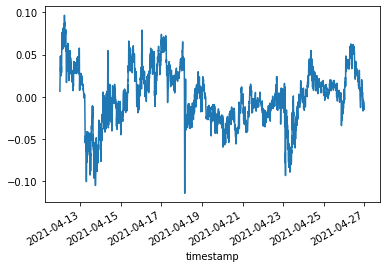

In [55]:
from matplotlib.pyplot import figure

#figure(figsize=(18, 16), dpi=80)

y_residual1.plot()

<AxesSubplot:xlabel='timestamp'>

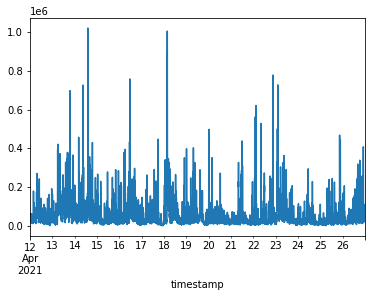

In [54]:
vol.plot()